----------------------------------
**Nguyễn Thành Long - 103210051 - 21HTCN**  

-----------------------------

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow --quiet
!pip install scikit-learn --quiet

# Hands on: LSTM-based Forecasting of Control Commands from Sensor Data

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train1.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test1.csv')

train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df.set_index('timestamp', inplace=True)

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df.set_index('timestamp', inplace=True)

In [ ]:
train_df.head()

,cc1,cc2,sen1,sen2,sen3,sys_tem,cool_tem,sur_tem
timestamp,,,,,,,,
2023-01-01 00:00:00,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2023-01-01 00:00:01,0.0,0.0,0.000789,0.0,0.0,0.0,0.000021,0.001229
2023-01-01 00:00:02,0.0,0.0,0.003115,0.0,0.0,0.0,0.000104,0.004833
2023-01-01 00:00:03,0.0,0.0,0.006914,0.0,0.0,0.0,0.000285,0.010688
2023-01-01 00:00:04,0.0,0.0,0.012123,0.0,0.0,0.0,0.000601,0.018669


In [ ]:
test_df.head()

,cc1,cc2,sen1,sen2,sen3,sys_tem,cool_tem,sur_tem
timestamp,,,,,,,,
2023-01-04 00:00:01,1.0,1.0,1.000012,-0.051788,0.405058,446.309906,-8.017637,49.515604
2023-01-04 00:00:02,1.0,1.0,1.000012,0.031037,0.405605,446.277091,-8.020647,49.487162
2023-01-04 00:00:03,1.0,1.0,1.000012,0.120105,0.406167,446.210386,-8.023369,49.458824
2023-01-04 00:00:04,1.0,1.0,1.000012,0.214298,0.406740,446.113216,-8.025859,49.431020
2023-01-04 00:00:05,1.0,1.0,1.000012,0.312494,0.407323,445.988539,-8.028014,49.404168


## 1. Prepare input data for LSTM model



The input to every LSTM layer must be three-dimensional. The three dimensions of this input are:

`X`: a 3-dimensional array with shape (samples, timesteps, features)
- **Samples**: One sequence is one sample. A batch is comprised of one or more samples.

- **Time Steps** : One time step is one point of observation in the sample.

- **Features**: One feature is one observation at a time step.

`y`: a 2-dimensional array with shape (samples, targets), containing 3 binary variables.

Reference: https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

In [ ]:
# split data into X,y
X_train = train_df[['sen1', 'sen2', 'sen3', 'sys_tem', 'cool_tem', 'sur_tem']].values
y_train = train_df[['cc1', 'cc2']].values

X_test = test_df[['sen1', 'sen2', 'sen3', 'sys_tem', 'cool_tem', 'sur_tem']].values
y_test = test_df[['cc1', 'cc2']].values

In [ ]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Create time series (using sliding window)

def create_sequences(X, y, timesteps=60):
    Xs, ys = [], []
    for i in range(timesteps, len(X)):
        Xs.append(X[i-timesteps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_train_scaled, y_train, timesteps=60)
X_test, y_test = create_sequences(X_test_scaled, y_test, timesteps=60)


print("Train X shape:", X_train.shape)
print("Train Y shape:", y_train.shape)
print("Test X shape:", X_test.shape)
print("Test Y shape:", y_test.shape)

Train X shape: (259140, 60, 6)
Train Y shape: (259140, 2)
Test X shape: (51780, 60, 6)
Test Y shape: (51780, 2)


## 2. Build the LSTM Model

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs:", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Wed Apr 23 18:57:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P0             30W /   70W |     638MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
model = Sequential()
model.add(Input(shape=(60, 6)))

# LSTM layer 1
model.add(LSTM(128, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'))
model.add(Dropout(0.3))

# LSTM layer 2
model.add(LSTM(128, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'))
model.add(Dropout(0.3))

# LSTM layer 3
model.add(LSTM(64, return_sequences=False, activation='tanh', recurrent_activation='sigmoid'))
model.add(Dropout(0.3))

# Output
model.add(Dense(2, activation='sigmoid'))

# Compile
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,242 (977.51 KB)

 Trainable params: 250,242 (977.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

checkpoint = ModelCheckpoint('model_1.h5',monitor='val_loss',save_best_only=True,verbose=1)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/100
2023/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6231 - loss: 0.4566
Epoch 1: val_loss improved from inf to 0.27918, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.6232 - loss: 0.4565 - val_accuracy: 0.6459 - val_loss: 0.2792
Epoch 2/100
2022/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6811 - loss: 0.2546
Epoch 2: val_loss improved from 0.27918 to 0.18712, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - accuracy: 0.6811 - loss: 0.2546 - val_accuracy: 0.7168 - val_loss: 0.1871
Epoch 3/100
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6970 - loss: 0.1872
Epoch 3: val_loss improved from 0.18712 to 0.13884, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.6970 - loss: 0.1872 - val_accuracy: 0.6868 - val_loss: 0.1388
Epoch 4/100
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6975 - loss: 0.1487
Epoch 4: val_loss improved from 0.13884 to 0.11681, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.6975 - loss: 0.1487 - val_accuracy: 0.6931 - val_loss: 0.1168
Epoch 5/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7015 - loss: 0.1398
Epoch 5: val_loss improved from 0.11681 to 0.10711, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7015 - loss: 0.1398 - val_accuracy: 0.6955 - val_loss: 0.1071
Epoch 6/100
2023/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7027 - loss: 0.1231
Epoch 6: val_loss improved from 0.10711 to 0.09883, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7028 - loss: 0.1231 - val_accuracy: 0.6858 - val_loss: 0.0988
Epoch 7/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7066 - loss: 0.1283
Epoch 7: val_loss did not improve from 0.09883
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7066 - loss: 0.1283 - val_accuracy: 0.6858 - val_loss: 0.1224
Epoch 8/100
2023/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7044 - loss: 0.1170
Epoch 8: val_loss improved from 0.09883 to 0.09492, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - accuracy: 0.7043 - loss: 0.1170 - val_accuracy: 0.6814 - val_loss: 0.0949
Epoch 9/100
2022/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7036 - loss: 0.1053
Epoch 9: val_loss improved from 0.09492 to 0.08870, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.7036 - loss: 0.1053 - val_accuracy: 0.6845 - val_loss: 0.0887
Epoch 10/100
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7038 - loss: 0.1019
Epoch 10: val_loss did not improve from 0.08870
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.7038 - loss: 0.1019 - val_accuracy: 0.6520 - val_loss: 0.3306
Epoch 11/100
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7048 - loss: 0.1287
Epoch 11: val_loss improved from 0.08870 to 0.08216, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.7048 - loss: 0.1287 - val_accuracy: 0.6907 - val_loss: 0.0822
Epoch 12/100
2023/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7051 - loss: 0.0956
Epoch 12: val_loss improved from 0.08216 to 0.07651, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.7051 - loss: 0.0956 - val_accuracy: 0.6889 - val_loss: 0.0765
Epoch 13/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6908 - loss: 0.1492
Epoch 13: val_loss did not improve from 0.07651
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.6908 - loss: 0.1492 - val_accuracy: 0.6856 - val_loss: 0.0856
Epoch 14/100
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7055 - loss: 0.0927
Epoch 14: val_loss did not improve from 0.07651
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.7055 - loss: 0.0927 - val_accuracy: 0.6945 - val_loss: 0.0789
Epoch 15/100
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7040 - loss: 0.0897
Epoch 15: val_loss did not improve from 0.07651
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7040 - loss: 0.0897 - val_accuracy: 0.6919 - val_loss: 0.0802
Epoch 16/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7079 - loss: 0.1050
Epoch 16

2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7079 - loss: 0.1050 - val_accuracy: 0.6989 - val_loss: 0.0764
Epoch 17/100
2022/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7050 - loss: 0.0892
Epoch 17: val_loss did not improve from 0.07639
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7050 - loss: 0.0892 - val_accuracy: 0.6959 - val_loss: 0.0875
Epoch 18/100
2023/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7067 - loss: 0.0848
Epoch 18: val_loss did not improve from 0.07639
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - accuracy: 0.7067 - loss: 0.0848 - val_accuracy: 0.6948 - val_loss: 0.0839
Epoch 19/100
2023/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7000 - loss: 0.0978
Epoch 19: val_loss did not improve from 0.07639
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.7000 - loss: 0.0978 - val_accuracy: 0.6877 - val_loss: 0.0838
Epoch 20/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7053 - loss: 0.0864
Epoch 20

2025/2025 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.7075 - loss: 0.0799 - val_accuracy: 0.6904 - val_loss: 0.0685
Epoch 22/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7058 - loss: 0.0841
Epoch 22: val_loss did not improve from 0.06853
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.7058 - loss: 0.0841 - val_accuracy: 0.6937 - val_loss: 0.0729
Epoch 23/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7069 - loss: 0.0790
Epoch 23: val_loss improved from 0.06853 to 0.06779, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7069 - loss: 0.0790 - val_accuracy: 0.6873 - val_loss: 0.0678
Epoch 24/100
2023/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7054 - loss: 0.0765
Epoch 24: val_loss did not improve from 0.06779
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.7054 - loss: 0.0765 - val_accuracy: 0.7013 - val_loss: 0.0761
Epoch 25/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7065 - loss: 0.0775
Epoch 25: val_loss improved from 0.06779 to 0.06385, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7065 - loss: 0.0775 - val_accuracy: 0.6940 - val_loss: 0.0638
Epoch 26/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7051 - loss: 0.0739
Epoch 26: val_loss improved from 0.06385 to 0.06251, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.7051 - loss: 0.0739 - val_accuracy: 0.6943 - val_loss: 0.0625
Epoch 27/100
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7010 - loss: 0.1054
Epoch 27: val_loss did not improve from 0.06251
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.7010 - loss: 0.1054 - val_accuracy: 0.6911 - val_loss: 0.0750
Epoch 28/100
2022/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7073 - loss: 0.0760
Epoch 28: val_loss did not improve from 0.06251
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7072 - loss: 0.0760 - val_accuracy: 0.6799 - val_loss: 0.0705
Epoch 29/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7057 - loss: 0.0743
Epoch 29: val_loss improved from 0.06251 to 0.06057, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.7057 - loss: 0.0743 - val_accuracy: 0.6921 - val_loss: 0.0606
Epoch 30/100
2022/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7035 - loss: 0.1030
Epoch 30: val_loss did not improve from 0.06057
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.7034 - loss: 0.1032 - val_accuracy: 0.6751 - val_loss: 0.1099
Epoch 31/100
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6982 - loss: 0.0868
Epoch 31: val_loss did not improve from 0.06057
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.6982 - loss: 0.0868 - val_accuracy: 0.6917 - val_loss: 0.0631
Epoch 32/100
2022/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7045 - loss: 0.0713
Epoch 32: val_loss improved from 0.06057 to 0.06012, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.7045 - loss: 0.0713 - val_accuracy: 0.6912 - val_loss: 0.0601
Epoch 33/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7011 - loss: 0.0804
Epoch 33: val_loss improved from 0.06012 to 0.05888, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.7011 - loss: 0.0804 - val_accuracy: 0.6885 - val_loss: 0.0589
Epoch 34/100
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7052 - loss: 0.0745
Epoch 34: val_loss did not improve from 0.05888
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7052 - loss: 0.0745 - val_accuracy: 0.6850 - val_loss: 0.0612
Epoch 35/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7034 - loss: 0.0723
Epoch 35: val_loss improved from 0.05888 to 0.05764, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.7034 - loss: 0.0723 - val_accuracy: 0.6888 - val_loss: 0.0576
Epoch 36/100
2023/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6987 - loss: 0.0803
Epoch 36: val_loss improved from 0.05764 to 0.05468, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - accuracy: 0.6987 - loss: 0.0803 - val_accuracy: 0.6903 - val_loss: 0.0547
Epoch 37/100
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7033 - loss: 0.0683
Epoch 37: val_loss did not improve from 0.05468
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.7033 - loss: 0.0683 - val_accuracy: 0.6796 - val_loss: 0.0601
Epoch 38/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7036 - loss: 0.0686
Epoch 38: val_loss did not improve from 0.05468
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.7036 - loss: 0.0686 - val_accuracy: 0.6850 - val_loss: 0.0672
Epoch 39/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7032 - loss: 0.0744
Epoch 39: val_loss improved from 0.05468 to 0.05358, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.7032 - loss: 0.0744 - val_accuracy: 0.6903 - val_loss: 0.0536
Epoch 40/100
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7026 - loss: 0.0638
Epoch 40: val_loss improved from 0.05358 to 0.05303, saving model to model_1.h5


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.7026 - loss: 0.0638 - val_accuracy: 0.6839 - val_loss: 0.0530
Epoch 41/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7014 - loss: 0.0735
Epoch 41: val_loss did not improve from 0.05303
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.7014 - loss: 0.0735 - val_accuracy: 0.6701 - val_loss: 0.2084
Epoch 42/100
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6931 - loss: 0.1725
Epoch 42: val_loss did not improve from 0.05303
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.6931 - loss: 0.1724 - val_accuracy: 0.6910 - val_loss: 0.0669
Epoch 43/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7005 - loss: 0.0709
Epoch 43: val_loss did not improve from 0.05303
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.7005 - loss: 0.0709 - val_accuracy: 0.6992 - val_loss: 0.0551
Epoch 44/100
2024/2025 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7068 - loss: 0.0652
Epoch 44

## 3. Model Validation

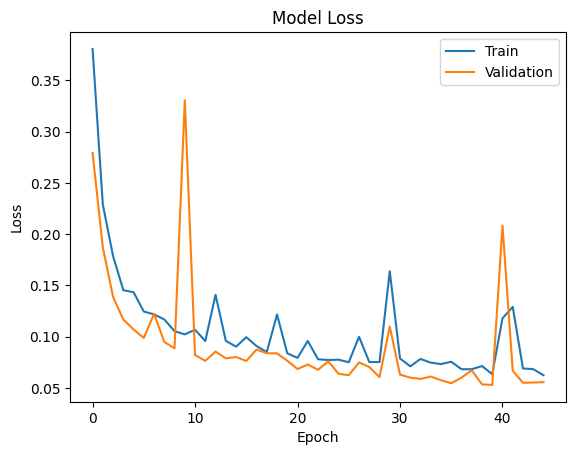

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
best_model = tf.keras.models.load_model('/content/model_1.h5')
test_loss = best_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

1619/1619 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7146 - loss: 0.0516
Test Loss: [0.053026504814624786, 0.6838547587394714]


In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

1619/1619 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step


In [ ]:
import numpy as np
from tensorflow import keras


model = keras.models.load_model('model_1.h5')

y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print("Predict vs Actual :")
for i in range(10):
#for i in range(len(y_test)):
    thuc_te = y_test[i]
    du_doan = y_pred[i]
    print(f"Test {i+1}: Actual={thuc_te}, Predict={du_doan}")

sai_so = np.sum(np.abs(y_test - y_pred))
print(f"\nTổng số lỗi: {sai_so}")

1619/1619 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
Predict vs Actual :
Test 1: Actual=[1. 1.], Predict=[1 1]
Test 2: Actual=[1. 1.], Predict=[1 1]
Test 3: Actual=[1. 1.], Predict=[1 1]
Test 4: Actual=[1. 1.], Predict=[1 1]
Test 5: Actual=[1. 1.], Predict=[1 1]
Test 6: Actual=[1. 1.], Predict=[1 1]
Test 7: Actual=[1. 1.], Predict=[1 1]
Test 8: Actual=[1. 1.], Predict=[1 1]
Test 9: Actual=[1. 1.], Predict=[1 1]
Test 10: Actual=[1. 1.], Predict=[1 1]

Tổng số lỗi: 1655.0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# precision, recall, F1-score cho từng lớp
precision_cc1 = precision_score(y_test[:, 0], y_pred[:, 0])
recall_cc1 = recall_score(y_test[:, 0], y_pred[:, 0])
f1_cc1 = f1_score(y_test[:, 0], y_pred[:, 0])

precision_cc2 = precision_score(y_test[:, 1], y_pred[:, 1])
recall_cc2 = recall_score(y_test[:, 1], y_pred[:, 1])
f1_cc2 = f1_score(y_test[:, 1], y_pred[:, 1])

print("Precision (cc1):", precision_cc1)
print("Recall (cc1):", recall_cc1)
print("F1-score (cc1):", f1_cc1)

print("Precision (cc2):", precision_cc2)
print("Recall (cc2):", recall_cc2)
print("F1-score (cc2):", f1_cc2)

Accuracy: 0.9682116647354191
Precision (cc1): 0.987995377101741
Recall (cc1): 0.986744610343672
F1-score (cc1): 0.9873695976154993
Precision (cc2): 0.9815406570905594
Recall (cc2): 0.9880699562773266
F1-score (cc2): 0.9847944843042348
